# Diplomski rad 05
12\. lipnja 2017.

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import graphviz as gv

import networkx as nx
import pydot
import os
from utility.log_progress import log_progress
from importlib import reload
import utility.functions
reload(utility.functions)
from utility.functions import *
from collections import Counter

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
sp500 = np.genfromtxt('data/stock_prices_sp500.csv', delimiter=',')

# smanjivanje skupa podataka
# sp500 = sp500[1000:2000, :]

days, N = sp500.shape
P = N * (N - 1) // 2

# log-cijene
sp500_log = np.log(sp500)

# razlike log cijena po parovima
sp500_log_diffs = calculate_pairwise_diffs(sp500_log)

## Prikaz ovisnosti profita i Sharpeovog omjera o duljini perioda T

In [55]:
method = 'thresh-devs'
startT = 60; endT = 250; stepT = 2
ps = np.random.permutation(P)[:10]
results = np.zeros([len(range(startT, endT + 1, stepT)), len(ps)])
results_sharpe = np.zeros([len(range(startT, endT + 1, stepT)), len(ps)])

for Ti, T in log_progress(list(enumerate(range(startT, endT + 1, stepT)))):
    for pi, p in enumerate(ps):
        sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs[:, np.newaxis, p], T)
        
        ts, profits, pairs, weights = statistical_arbitrage(sp500_log_diffs[:, np.newaxis, p], sp500_log_diff_means,
                                                            sp500_log_diff_vars, p=None, d=0,
                                                            method=method, return_pairs=True, return_weights=True)
        ppairs = partition_as(ts, pairs, weights)
        profit = []
        shares = []
        ts_plot = []
        exp_tops = []
        exp_bottoms = []
        for t, ppair, weight in list(ppairs):
            preferences = calculate_preference_flow(ppair, weights=weight, scale=True)
            m = max(np.abs(list(preferences.values())))
            tops = np.array([k for k, v in preferences.items() if v >= m])
            bottoms = np.array([k for k, v in preferences.items() if -m >= v])
            g = []
            if len(tops) != 0:
                ttops = np.array([t] * len(tops))
                g.extend(trade_singles(sp500_log, ttops, tops, inv=False))
                shares.extend(tops)
                ts_plot.extend(ttops)
            if len(bottoms) != 0:
                tbottoms = np.array([t] * len(bottoms))
                g.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
                shares.extend(bottoms)
                ts_plot.extend(tbottoms)
            if len(tops) == 0 and len(bottoms) == 0:
                ts_plot.append(t)
                profit.append(0)
            exp_tops += [set(tops)]
            exp_bottoms += [set(bottoms)]
            profit.extend([p_ / len(g) for p_ in g])

        shares = np.array(shares)
        ts_plot = np.array(ts_plot)
        profit = np.array(profit)

        ts1, profit1 = join_ts_profit(ts_plot, profit)
        
        turnover_top = turnover_ratio(exp_tops)
        turnover_bottom = turnover_ratio(exp_bottoms)

        avg = np.mean(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 0) * 252
        std = np.std(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 0) * np.sqrt(252)
        sharpe = avg / std
        profit2 = np.sum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 0)
            
        results[Ti, pi] = profit2
        results_sharpe[Ti, pi] = sharpe
        

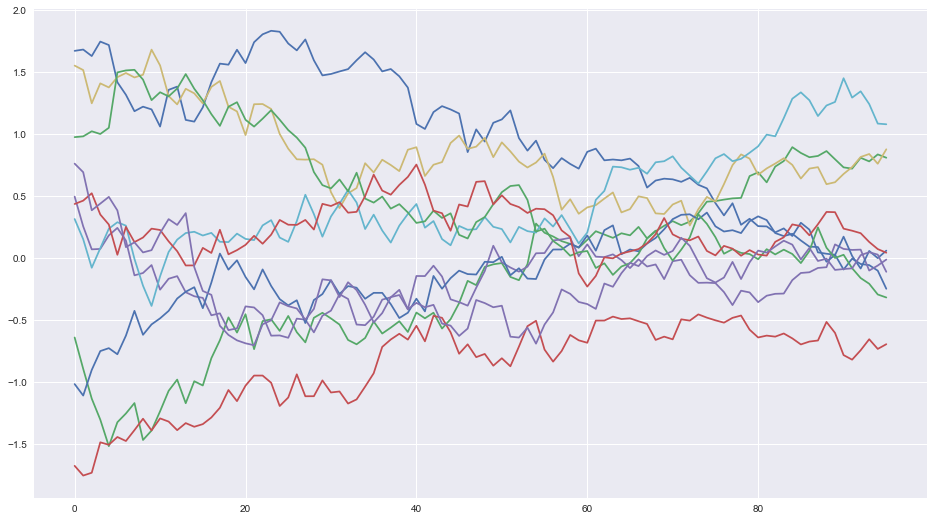

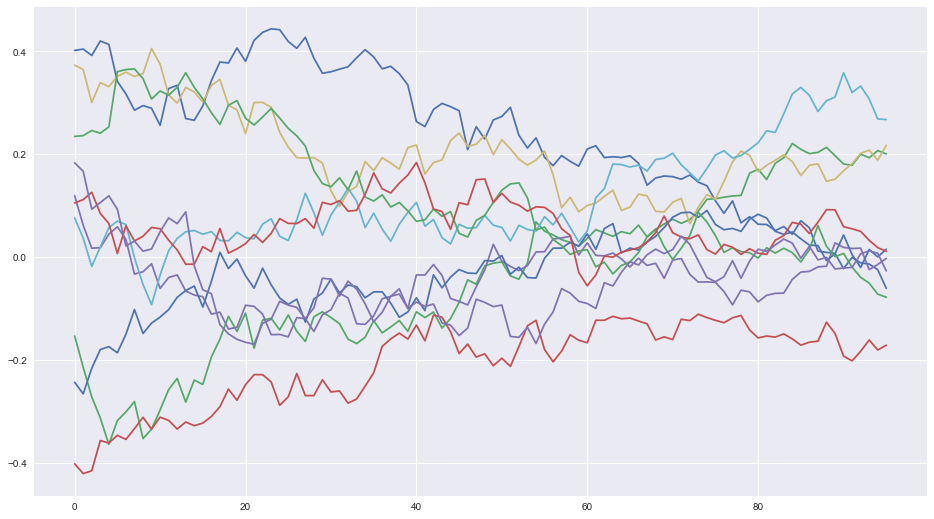

In [70]:
plt.figure()
plt.plot(results)
plt.figure()
plt.plot(results_sharpe);

## Izračunavanje optimalnog perioda T za svaki par dionica

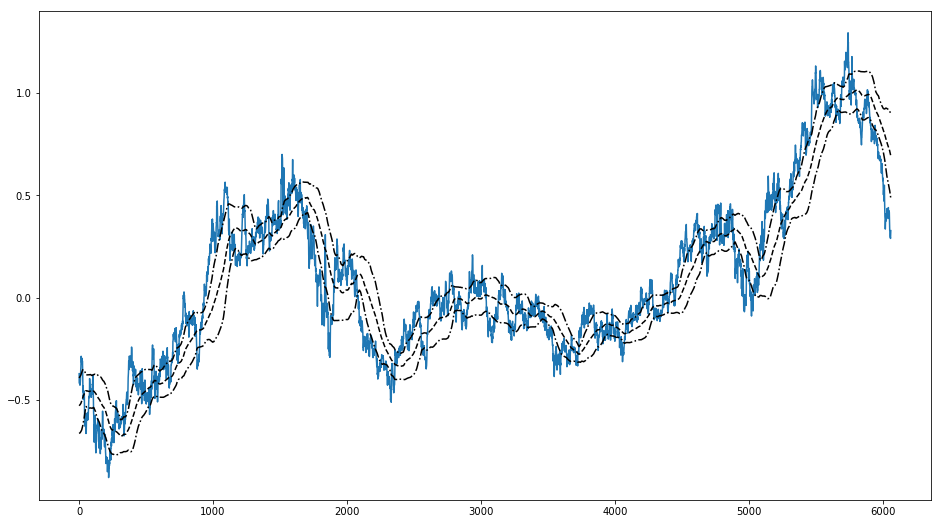

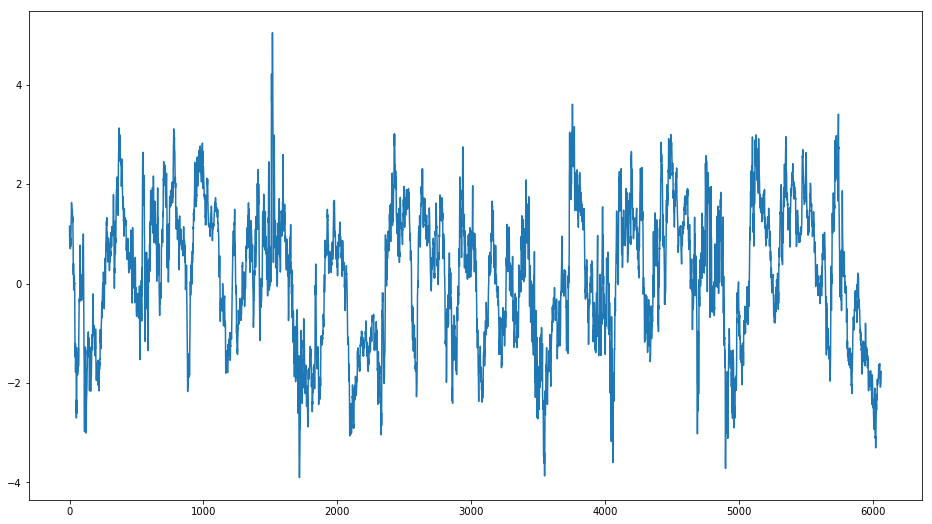

In [8]:
T = 200
p = 10
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(sp500_log_diffs, T)
plt.figure()
plt.plot(sp500_log_diffs[T:, p])
plt.plot(sp500_log_diff_means[:-1, p], 'k--')
plt.plot(sp500_log_diff_means[:-1, p] - np.sqrt(sp500_log_diff_vars[:-1, p]), 'k-.')
plt.plot(sp500_log_diff_means[:-1, p] + np.sqrt(sp500_log_diff_vars[:-1, p]), 'k-.')
plt.figure()
plt.plot((sp500_log_diffs[T:, p] - sp500_log_diff_means[:-1, p]) / np.sqrt(sp500_log_diff_vars[:-1, p]));

In [309]:
startT = 4; endT = 120; stepT = 4
energies1 = np.zeros([len(range(startT, endT + 1, stepT)), P])
energies2 = np.zeros([len(range(startT, endT + 1, stepT)), P])
data = sp500_log_diffs[5000:5240]
for Ti, T in enumerate(log_progress(list(range(startT, endT + 1, stepT)))):
    sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(data, T)
    normalized = (data[T-1:] - sp500_log_diff_means) / np.sqrt(sp500_log_diff_vars)
    energies1[Ti, :] = np.var(normalized, axis=0)
    energies2[Ti, :] = np.mean(normalized ** 2, axis=0)


C:\Users\Helena\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


[6613]
Optimal T1: 120
Optimal T2: 28


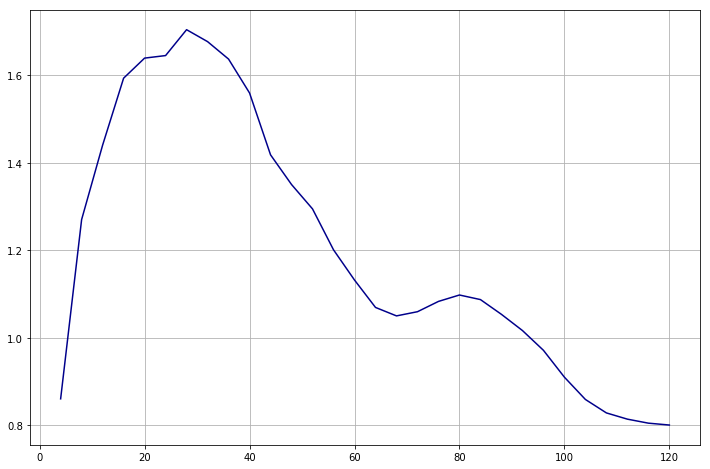

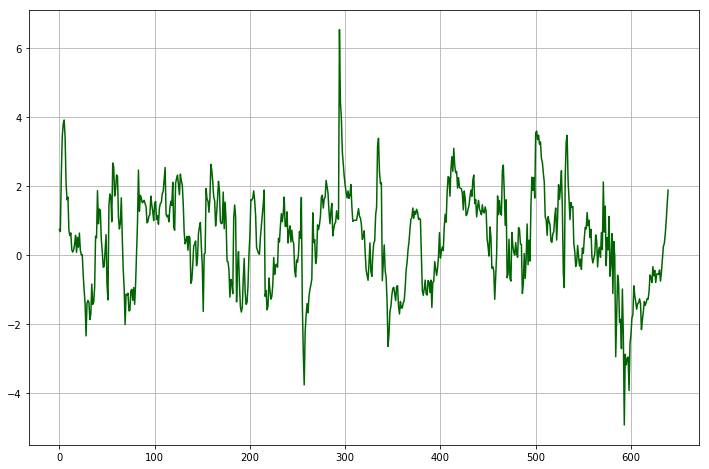

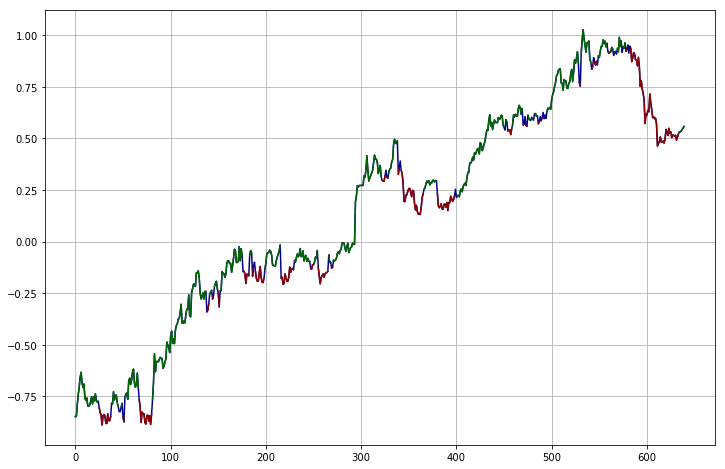

In [368]:
data = sp500_log_diffs[5240:6000]
p = np.random.permutation(P)[:1]
p = [6613]
print(p)
plt.figure()
plt.plot(np.arange(startT, endT + stepT, stepT).reshape([-1, 1]), energies1[:, p], 'darkblue');
# plt.plot(energies2[:, p], 'darkgreen');
plt.grid()
t_optimal1 = np.squeeze(np.nanargmin(energies1[:, p], axis=0)) * stepT + startT
t_optimal2 = np.squeeze(np.nanargmax(energies1[:, p], axis=0)) * stepT + startT
plot_t = max(t_optimal1, t_optimal2)
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(data[:, p], t_optimal1)
normalized1 = (data[plot_t:, p] - sp500_log_diff_means[plot_t - t_optimal1:-1]) / np.sqrt(sp500_log_diff_vars[plot_t - t_optimal1:-1])
sp500_log_diff_means, sp500_log_diff_vars = rolling_mean_variance(data[:, p], t_optimal2)
normalized2 = (data[plot_t:, p] - sp500_log_diff_means[plot_t - t_optimal2:-1]) / np.sqrt(sp500_log_diff_vars[plot_t - t_optimal2:-1])
plt.figure()
# plt.plot(normalized1, 'darkblue')
plt.plot(normalized2, 'darkgreen')
plt.grid()
plt.figure()
data_1 = data[plot_t:, p]
data_2 = data[plot_t:, p]
d = 0.0
data_1[normalized2 > -d] = np.nan
data_2[normalized2 < d] = np.nan
plt.plot(data[plot_t:, p], 'darkblue')
plt.plot(data_1, 'darkred')
plt.plot(data_2, 'darkgreen')
plt.grid()
print('Optimal T1: {}'.format(t_optimal1))
print('Optimal T2: {}'.format(t_optimal2))

In [342]:
optimal_Ts1 = np.nanargmin(energies1, axis=0) * 4 + 4
optimal_Ts2 = np.nanargmax(energies1, axis=0) * 4 + 4

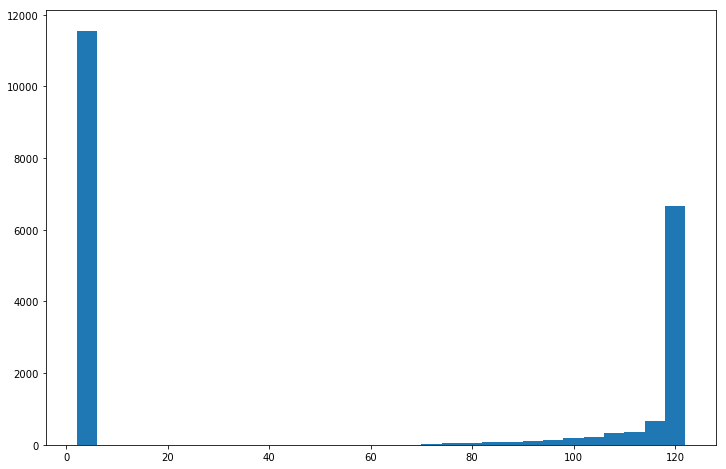

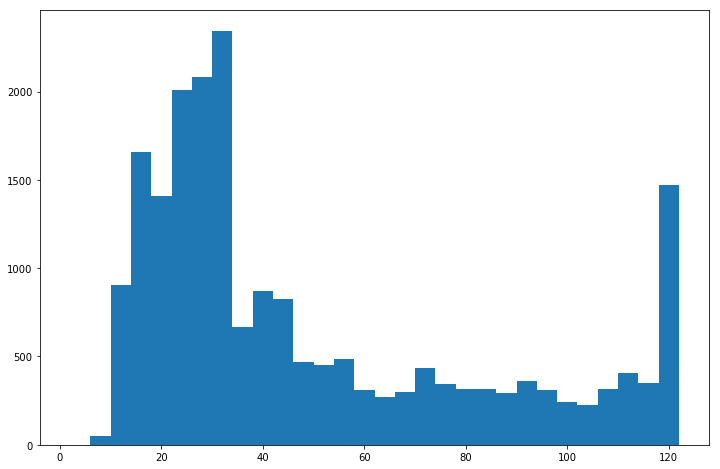

In [369]:
plt.figure()
plt.hist(optimal_Ts1, np.arange(startT - stepT / 2, endT + stepT + stepT / 2, stepT));
plt.figure()
plt.hist(optimal_Ts2, np.arange(startT - stepT / 2, endT + stepT + stepT / 2, stepT));

In [338]:
optimal_Ts = (np.nanargmin(energies, axis=0) + 1) * 4
outliers = set(np.where(optimal_Ts > 180)[0])

In [ ]:
endT = 120
sp500_log_diff_means = np.zeros([days - endT + 1, P])
sp500_log_diff_vars = np.zeros([days - endT + 1, P])
for p in log_progress(range(P)):
    if p in outliers:
        continue
    T = optimal_Ts[p]
    sp500_log_diff_mean, sp500_log_diff_var = rolling_mean_variance(sp500_log_diffs[:, np.newaxis, p], T)
    sp500_log_diff_means[:, p] = np.squeeze(sp500_log_diff_mean[endT - T:])
    sp500_log_diff_vars[:, p] = np.squeeze(sp500_log_diff_var[endT - T:])

In [29]:
method = 'thresh-devs'
ts, profits, pairs, weights = statistical_arbitrage(sp500_log_diffs, sp500_log_diff_means,
                                                    sp500_log_diff_vars, p=None, d=0,
                                                    method=method, return_pairs=True, return_weights=True)

C:\Users\Helena\ipynb\utility\functions.py:216: RuntimeWarning: divide by zero encountered in true_divide
  / np.sqrt(varss[ts_invs - T + 1, invs]),
C:\Users\Helena\ipynb\utility\functions.py:218: RuntimeWarning: divide by zero encountered in true_divide
  / np.sqrt(varss[ts_no_invs - T + 1, no_invs])))[ts_order, ...]) - d


In [60]:
ppairs = partition_as(ts, pairs, weights)
profit = []
shares = []
ts_plot = []
exp_tops = []
exp_bottoms = []
for t, ppair, weight in log_progress(list(ppairs)):
    valids = [i not in outliers for i in encode_pairs(ppair, N)]
    ppair = ppair[valids]
    weight = weight[valids]
    preferences = calculate_preference_flow(ppair, weights=weight, scale=True)
    m = max(np.abs(list(preferences.values())))
    tops = np.array([k for k, v in preferences.items() if v >= m])
    bottoms = np.array([k for k, v in preferences.items() if -m >= v])
    g = []
    if len(tops) != 0:
        ttops = np.array([t] * len(tops))
        g.extend(trade_singles(sp500_log, ttops, tops, inv=False))
        shares.extend(tops)
        ts_plot.extend(ttops)
    if len(bottoms) != 0:
        tbottoms = np.array([t] * len(bottoms))
        g.extend(trade_singles(sp500_log, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts_plot.extend(tbottoms)
    if len(tops) == 0 and len(bottoms) == 0:
        ts_plot.append(t)
        profit.append(0)
    exp_tops += [set(tops)]
    exp_bottoms += [set(bottoms)]
    profit.extend([p_ / len(g) for p_ in g])
    
shares = np.array(shares)
ts_plot = np.array(ts_plot)
profit = np.array(profit)

In [61]:
ts1, profit1 = join_ts_profit(ts_plot, profit)

turnover_top = turnover_ratio(exp_tops)
turnover_bottom = turnover_ratio(exp_bottoms)

avg = np.mean(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * 252
std = np.std(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * np.sqrt(252)
sharpe = avg / std
profit2 = np.sum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3)

Total profit (transaction cost included): 11.07087
Avg (year): 0.48427
Stddev (year): 0.69877
Sharpe ratio (year): 0.69302
Average turnovers (range [0, 2]):
  top: 0.36747
  bottom: 0.40583
  total: 0.38665
Average accuracy: 0.48603


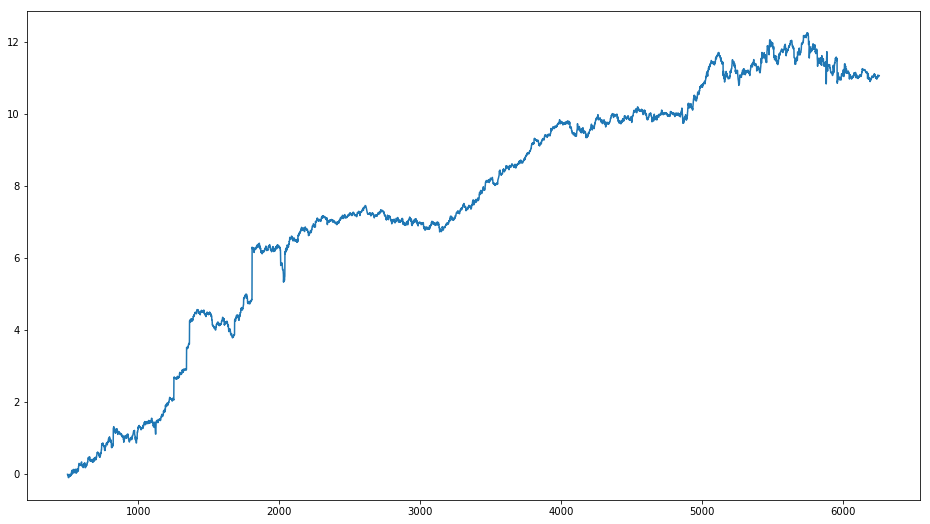

In [62]:
plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3))
print('Total profit (transaction cost included): {:.5f}'.format(profit2))
print('Avg (year): {:.5f}'.format(avg))
print('Stddev (year): {:.5f}'.format(std))
print('Sharpe ratio (year): {:.5f}'.format(sharpe))
print('Average turnovers (range [0, 2]):')
print('  top: {:.5f}'.format(np.mean(turnover_top)))
print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))

Total profit (transaction cost included): 22.46235
Avg (year): 0.98256
Stddev (year): 0.81792
Sharpe ratio (year): 1.20128
Average turnovers (range [0, 2]):
  top: 0.38344
  bottom: 0.43847
  total: 0.41095
Average accuracy: 0.50373


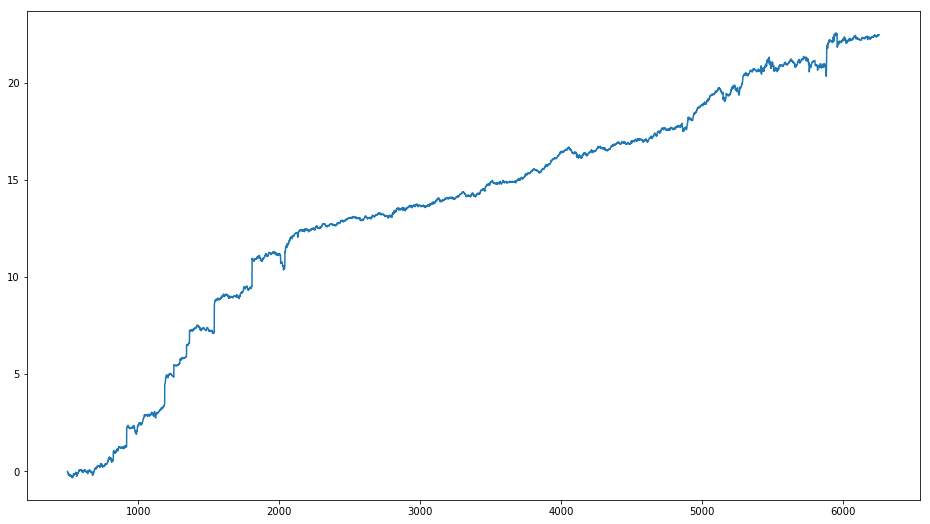

In [54]:
plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3))
print('Total profit (transaction cost included): {:.5f}'.format(profit2))
print('Avg (year): {:.5f}'.format(avg))
print('Stddev (year): {:.5f}'.format(std))
print('Sharpe ratio (year): {:.5f}'.format(sharpe))
print('Average turnovers (range [0, 2]):')
print('  top: {:.5f}'.format(np.mean(turnover_top)))
print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))

## Optimizacija perioda T

In [74]:
data = sp500_log_diffs[4000:5000]
opt = optimize_trading_signal(data, window_size=500, optimization_step=100, method='var')

C:\Users\Helena\ipynb\utility\functions.py:375: RuntimeWarning: invalid value encountered in sqrt
  trading_signal = (log_prices[t - window_size + T - 1:t] - log_price_means) / np.sqrt(log_price_vars)
C:\Users\Helena\ipynb\utility\functions.py:375: RuntimeWarning: divide by zero encountered in true_divide
  trading_signal = (log_prices[t - window_size + T - 1:t] - log_price_means) / np.sqrt(log_price_vars)
C:\Users\Helena\ipynb\utility\functions.py:375: RuntimeWarning: invalid value encountered in true_divide
  trading_signal = (log_prices[t - window_size + T - 1:t] - log_price_means) / np.sqrt(log_price_vars)
C:\Users\Helena\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [27]:
print(opt.shape)

(500, 20503)


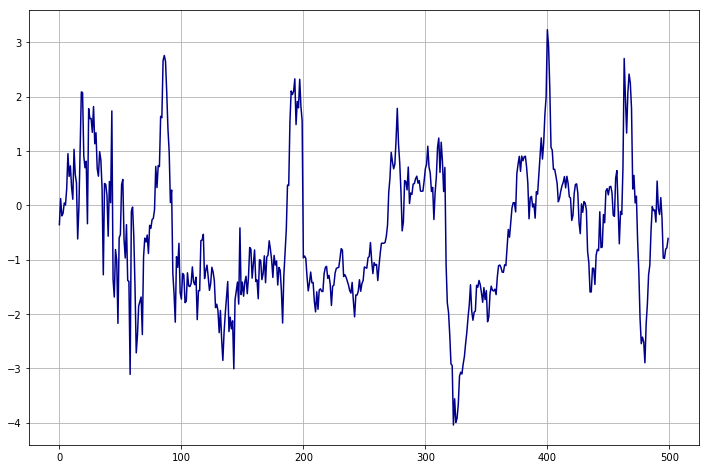

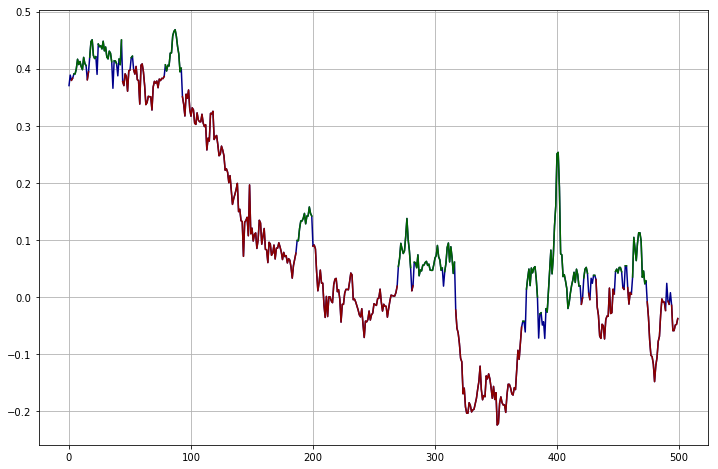

In [75]:
p = 22
plt.figure()
plt.plot(opt[:, p], 'darkblue')
plt.grid()

plt.figure()
data1 = np.array(data[500:])
data1[opt > 0] = np.nan
data2 = np.array(data[500:])
data2[opt < 0] = np.nan
plt.plot(data[500:, p], 'darkblue')
plt.plot(data1[:, p], 'darkred')
plt.plot(data2[:, p], 'darkgreen')
plt.grid()

In [86]:
# method = 'thresh-devs'
# ts_invs, invs = np.where(np.less(opt, 0))
# pair_invs = decode_pairs(invs, N, inv=True)
# ts_no_invs, no_invs = np.where(np.greater(opt, 0))
# pair_no_invs = decode_pairs(no_invs, N, inv=False)
# ts_total = np.concatenate([ts_invs, ts_no_invs], axis=0)
# ts_order = np.argsort(ts_total)
# ts = ts_total[ts_order] + 200
# pairs_total = np.concatenate([pair_invs, pair_no_invs], axis=0)
# pairs = pairs_total[ts_order]
# weights = np.abs(opt)[ts_order]

method = 'thresh-devs'
ts, codes = np.where(opt[:-1])
pairs = decode_pairs(codes, N, inv=True)
ts += 500
weights = opt[:-1].reshape([-1])


In [87]:
print(weights.shape)
print(ts.shape)

(10230997,)
(10230997,)


In [88]:
ppairs = partition_as(ts, pairs, weights)
profit = []
shares = []
ts_plot = []
exp_tops = []
exp_bottoms = []
consistencies = []

In [89]:
for t, ppair, weight in log_progress(list(ppairs)):
    preferences, c = calculate_preference_flow(ppair, weights=weight, return_consistency=True)
    c = np.sqrt(c)
    consistencies.append(c)
    m = max(np.abs(list(preferences.values())))
    tops = np.array([k for k, v in preferences.items() if v >= m * c])
    bottoms = np.array([k for k, v in preferences.items() if -m * c >= v])
    g = []
    if len(tops) != 0:
        ttops = np.array([t] * len(tops))
        g.extend(trade_singles(data, ttops, tops, inv=False))
        shares.extend(tops)
        ts_plot.extend(ttops)
    if len(bottoms) != 0:
        tbottoms = np.array([t] * len(bottoms))
        g.extend(trade_singles(data, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts_plot.extend(tbottoms)
    if len(tops) == 0 and len(bottoms) == 0:
        ts_plot.append(t)
        profit.append(0)
    exp_tops += [set(tops)]
    exp_bottoms += [set(bottoms)]
    profit.extend([p_ / len(g) for p_ in g])
    
shares = np.array(shares)
ts_plot = np.array(ts_plot)
profit = np.array(profit)
consistencies = np.array(consistencies)

In [90]:
ts1, profit1 = join_ts_profit(ts_plot, profit)

turnover_top = turnover_ratio(exp_tops)
turnover_bottom = turnover_ratio(exp_bottoms)

avg = np.mean(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * 252
std = np.std(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * np.sqrt(252)
sharpe = avg / std
profit2 = np.sum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3)

Total profit (transaction cost included): -0.82559
Avg (year): -0.41693
Stddev (year): 0.35126
Sharpe ratio (year): -1.18696
Average turnovers (range [0, 2]):
  top: 0.65531
  bottom: 0.69706
  total: 0.67619
Average accuracy: 0.46602


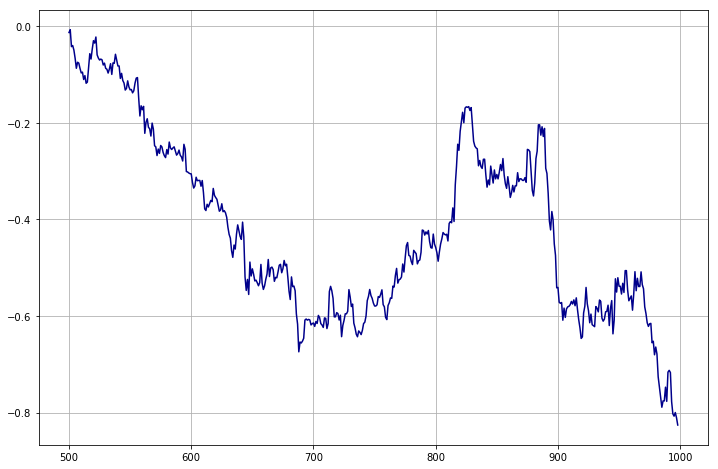

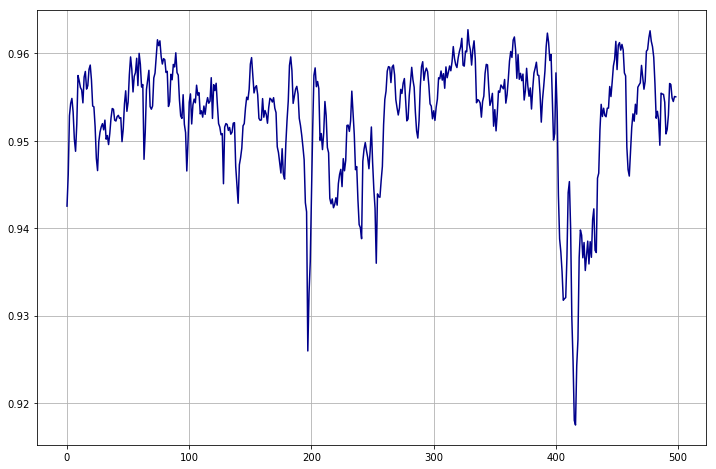

In [91]:
plt.figure()
plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3), 'darkblue')
plt.grid()

plt.figure()
plt.plot(consistencies, 'darkblue')
plt.grid()

print('Total profit (transaction cost included): {:.5f}'.format(profit2))
print('Avg (year): {:.5f}'.format(avg))
print('Stddev (year): {:.5f}'.format(std))
print('Sharpe ratio (year): {:.5f}'.format(sharpe))
print('Average turnovers (range [0, 2]):')
print('  top: {:.5f}'.format(np.mean(turnover_top)))
print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))

## Mjere različitosti

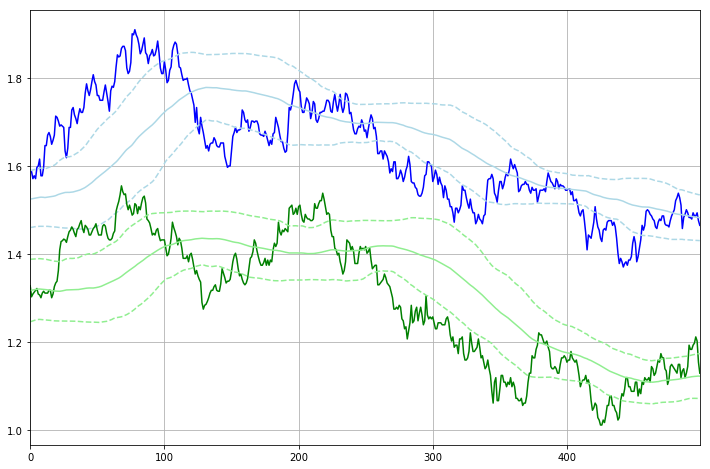

In [113]:
data = sp500_log[:500 + 120]
mean, var = rolling_mean_variance(data, T)
plt.plot(sp500_log[120:500 + 120, 0], c='blue')
plt.plot(mean[:-1, 0], c='lightblue', ls='-')
plt.plot(mean[:-1, 0] + np.sqrt(var[:-1, 0]), c='lightblue', ls='--')
plt.plot(mean[:-1, 0] - np.sqrt(var[:-1, 0]), c='lightblue', ls='--')
plt.plot(sp500_log[120:500 + 120, 1], c='green')
plt.plot(mean[:-1, 1], c='lightgreen', ls='-')
plt.plot(mean[:-1, 1] + np.sqrt(var[:-1, 1]), c='lightgreen', ls='--')
plt.plot(mean[:-1, 1] - np.sqrt(var[:-1, 1]), c='lightgreen', ls='--')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('ab-prices.svg', bbox_inches='tight')

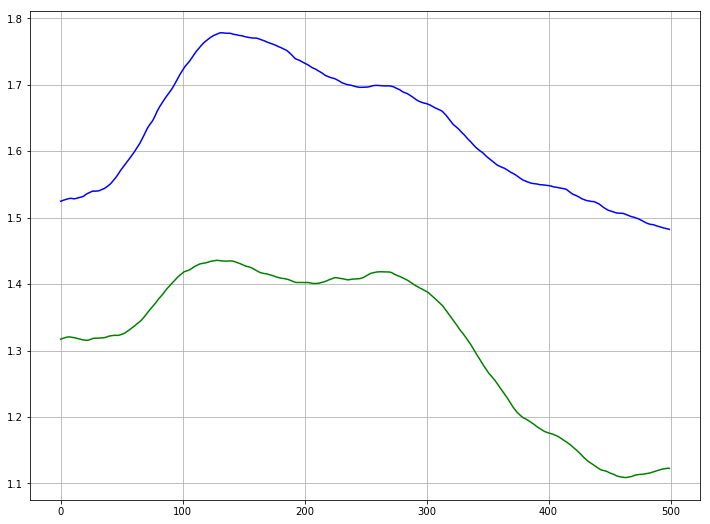

In [106]:
mean, var = rolling_mean_variance(sp500_log[:500 + 120, :2], 120)
plt.figure()
plt.plot(mean[:-1, 0], 'b')
plt.plot(mean[:-1, 1], 'g')
plt.grid()

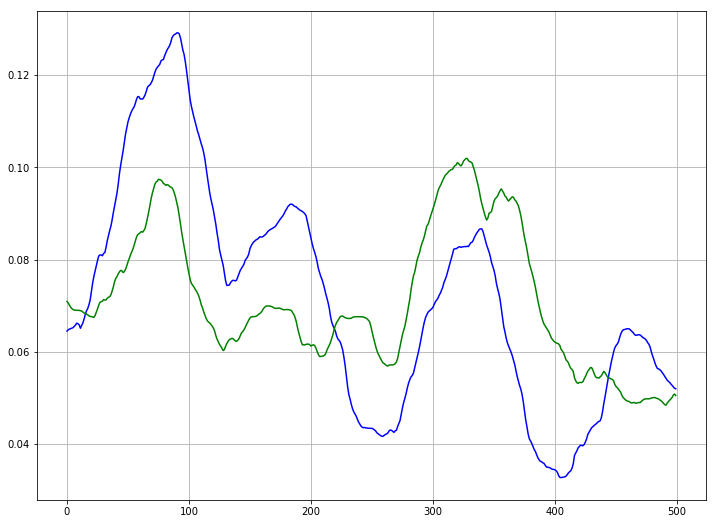

In [113]:
plt.figure()
plt.plot(np.sqrt(var[:-1, 0]), 'b')
plt.plot(np.sqrt(var[:-1, 1]), 'g')
plt.grid()

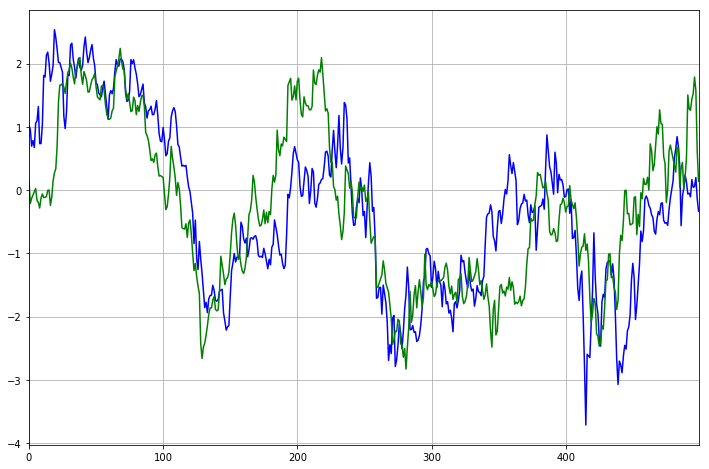

In [112]:
plt.figure()
plt.plot((sp500_log[120:500 + 120, 0] - mean[:-1, 0]) / np.sqrt(var[:-1, 0]), 'b')
plt.plot((sp500_log[120:500 + 120, 1] - mean[:-1, 1]) / np.sqrt(var[:-1, 1]), 'g')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('ab-prices-norm.svg', bbox_inches='tight')

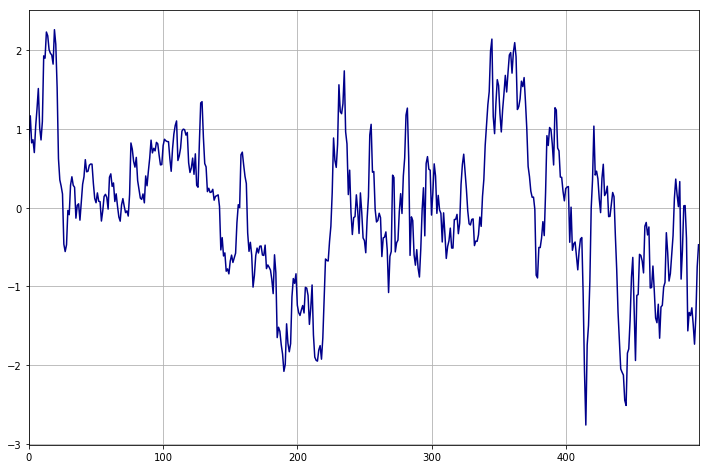

In [114]:
plt.figure()
plt.plot(((sp500_log[120:500 + 120, 0] - mean[:-1, 0]) / np.sqrt(var[:-1, 0])) - ((sp500_log[120:500 + 120, 1] - mean[:-1, 1]) / np.sqrt(var[:-1, 1])), color='darkblue')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('ab-prices-norm-diff.svg', bbox_inches='tight')

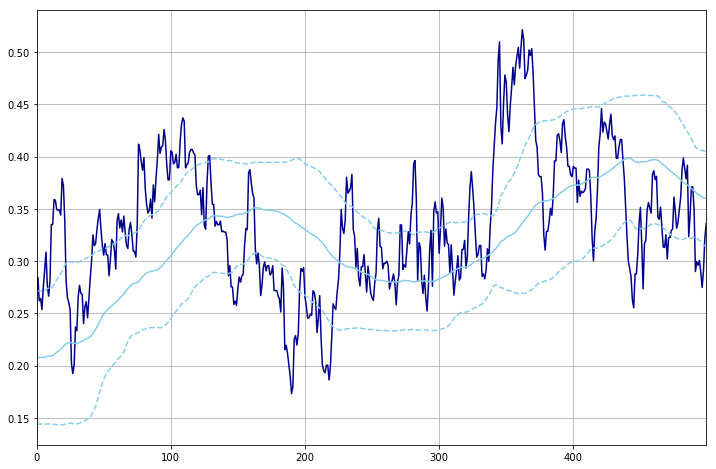

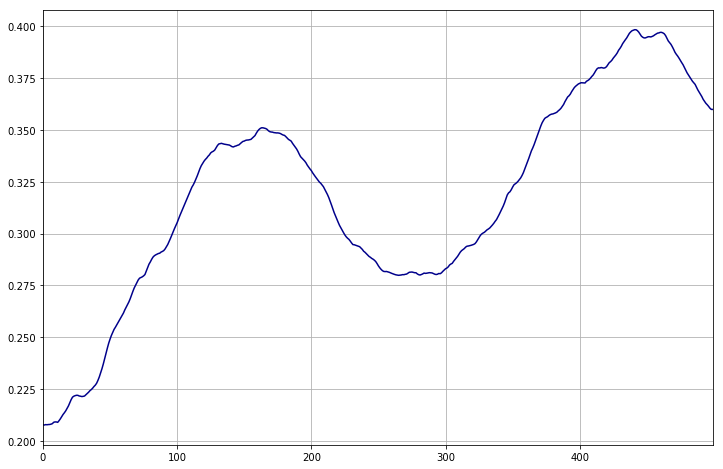

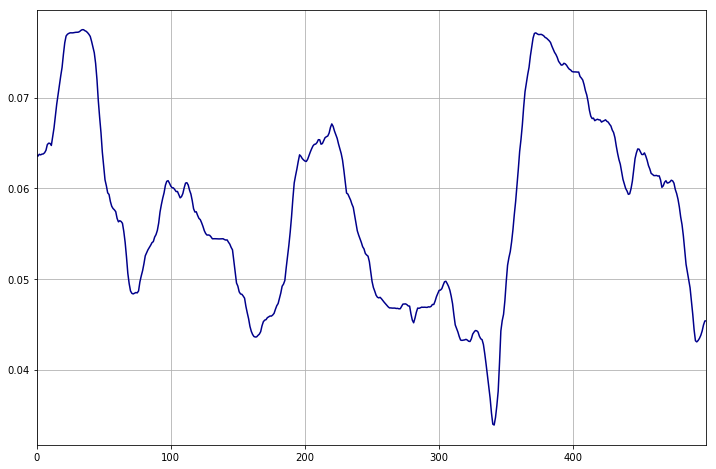

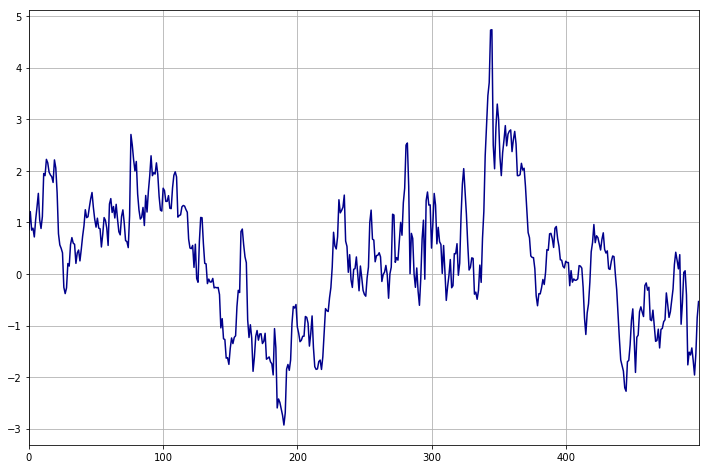

In [97]:
diff = sp500_log[:500 + 120, 0] - sp500_log[:500 + 120, 1]
dmean, dvar = rolling_mean_variance(diff[:, np.newaxis], 120)
plt.figure()
plt.plot(diff[120:], 'darkblue')
plt.plot(dmean[:-1], c='skyblue', ls='-')
plt.plot(dmean[:-1] - np.sqrt(dvar[:-1]), c='skyblue', ls='--')
plt.plot(dmean[:-1] + np.sqrt(dvar[:-1]), c='skyblue', ls='--')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('diff.svg', bbox_inches='tight')
plt.figure()
plt.plot(dmean[:-1], 'darkblue')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.figure()
plt.plot(np.sqrt(dvar[:-1]), 'darkblue')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.figure()
plt.plot((diff[120:, np.newaxis] - dmean[:-1]) / np.sqrt(dvar[:-1]), 'darkblue')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('diff-norm.svg', bbox_inches='tight')

In [95]:
import statsmodels.api as sm

T = 120
resid = np.zeros([500, 1])
reconstruct = np.zeros([500, 1])
for t in range(500):
    ols = sm.OLS(sp500_log[t:t+T, 0], sp500_log[t:t+T, 1]).fit()
    resid[t] = ols.resid[-1]
    reconstruct[t] = ols.predict(sp500_log[t, 1])


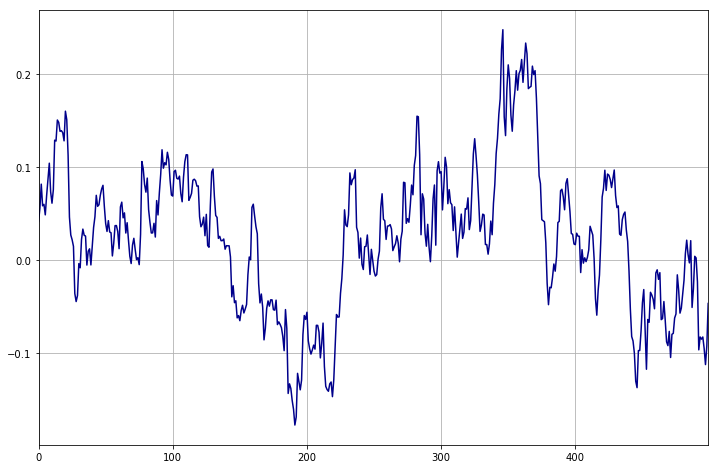

In [96]:
plt.figure()
plt.plot(resid, c='darkblue');
# plt.plot(sp500_log[120:500 + 120, 0])
# plt.plot(reconstruct)
# plt.plot(np.squeeze(reconstruct) - sp500_log[120:500 + 120, 0], c='green')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.savefig('residual.svg', bbox_inches='tight')

In [204]:
sp500_log[120:500 + 120, 0].shape

(500,)

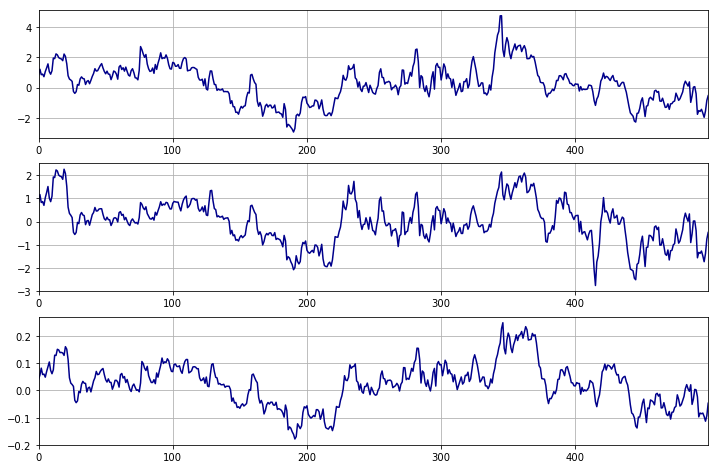

In [223]:
plt.figure()
plt.subplot(3, 1, 1)
plt.plot((diff[120:, np.newaxis] - dmean[:-1]) / np.sqrt(dvar[:-1]), 'darkblue')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(((sp500_log[120:500 + 120, 0] - mean[:-1, 0]) / np.sqrt(var[:-1, 0])) - ((sp500_log[120:500 + 120, 1] - mean[:-1, 1]) / np.sqrt(var[:-1, 1])), color='darkblue')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(resid, c='darkblue');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()
